In [10]:
import argparse
import random
import torch
import json
import sys

from utils.data_loader import load_data

In [11]:
def dataloader_to_numpy(dataloader):
    all_x, all_y, all_groups = [], [], []

    for batch in dataloader:
        x, y, group, *_ = batch 
        all_x.append(x)
        all_y.append(y)
        all_groups.append(group)

    X = torch.cat(all_x).numpy()
    y = torch.cat(all_y).numpy()
    groups = torch.cat(all_groups).numpy()
    
    return X, y, groups

def dataloader_to_numpy_trans(dataloader):
    all_x_categ, all_x_numer, all_y, all_groups = [], [], [], []

    for x_categ, x_numer, y, group, *_ in dataloader:
        all_x_categ.append(x_categ)
        all_x_numer.append(x_numer)
        all_y.append(y)
        all_groups.append(group)

    x_categ = torch.cat(all_x_categ).numpy()
    x_numer = torch.cat(all_x_numer).numpy()
    y = torch.cat(all_y).numpy()
    groups = torch.cat(all_groups).numpy()

    return x_categ, x_numer, y, groups

In [2]:
from utils.data_loader import load_data

config = {
  "dataset": "compas",
  "train_params": {
  }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, valid_loader, test_loader, train_df = load_data(config)

x_train, y_train, group_train = dataloader_to_numpy(train_loader)
x_valid, y_valid, group_vlaid = dataloader_to_numpy(valid_loader)
x_test, y_test, group_test = dataloader_to_numpy(test_loader)

NameError: name 'torch' is not defined

In [9]:
from sklearn.metrics import f1_score
import numpy as np

def find_best_threshold_for_f1(y_prob, y_true, num_thresholds=100):
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    best_f1 = 0.0
    best_threshold = 0.5

    for t in thresholds:
        y_pred = (y_prob > t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1

def predict_with_threshold(model, x, threshold=0.5):
    probs = model.predict_proba(x)[:, 1]  
    preds = (probs > threshold).astype(int)
    return preds

In [13]:
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    roc_auc_score, brier_score_loss
)
import numpy as np
import torch
import torch.nn.functional as F

def evaluate_group_metrics(model, test_loader, device, threshold):
    model.eval()
    model.to(device)

    all_logits = []
    all_preds = []
    all_labels = []
    all_groups = []

    is_tabtrans = model.__class__.__name__.lower() == "tabtransformer"

    with torch.no_grad():
        for batch in test_loader:
            if is_tabtrans:
                x_cat, x_num, y, g, *_ = batch
                x_cat = x_cat.to(device)
                x_num = x_num.to(device)
                x = (x_cat, x_num)
            else:
                x, y, g, *_ = batch
                x = x.to(device)

            outputs = model(x)  # raw logits
            probs = torch.sigmoid(outputs).flatten().cpu().numpy()
            preds = (probs > threshold).astype(int)

            all_logits.append(probs)
            all_preds.append(preds)
            all_labels.append(y.numpy())
            all_groups.append(g.numpy())

    y_prob = np.concatenate(all_logits)
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    group_ids = np.concatenate(all_groups)
    total = len(y_true)

    # 전체 metric
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    brier = brier_score_loss(y_true, y_prob)

    print(f"전체 AUC:       {auc:.4f}")
    print(f"전체 F1-score:  {f1:.4f}")
    print(f"전체 Recall:    {recall:.4f}")
    print(f"전체 Precision: {precision:.4f}")
    print(f"전체 Brier Score: {brier:.4f}")

    # 그룹별 요약
    print("\n그룹별 성능 요약:")
    print(f"{'Group':>6} | {'Ratio (%)':>9} | {'AUC':>6} | {'F1':>6} | {'Recall':>7} | {'Precision':>9}")
    print("-" * 60)

    for g in np.unique(group_ids):
        idx = group_ids == g
        group_size = np.sum(idx)
        ratio = group_size / total * 100

        y_true_g = y_true[idx]
        y_pred_g = y_pred[idx]
        y_prob_g = y_prob[idx]

        f1_g = f1_score(y_true_g, y_pred_g, zero_division=0)
        recall_g = recall_score(y_true_g, y_pred_g, zero_division=0)
        precision_g = precision_score(y_true_g, y_pred_g, zero_division=0)

        try:
            auc_g = roc_auc_score(y_true_g, y_prob_g)
        except ValueError:
            auc_g = float('nan')

        print(f"{g:>6} | {ratio:9.2f} | {auc_g:6.4f} | {f1_g:6.4f} | {recall_g:7.4f} | {precision_g:9.4f}")

In [ ]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

import logging
optuna_logger = logging.getLogger("optuna")
optuna_logger.setLevel(logging.WARNING)

# Objective 함수 정의
def objective(trial):
    params = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [3, 5, 7]),
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'eval_metric': 'logloss',
        'verbosity' : 0
    }

    model = XGBClassifier(**params)
    model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        verbose=False
    )

    pred_prob = model.predict_proba(x_valid)[:, 1]
    auc = roc_auc_score(y_valid, pred_prob)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

In [ ]:
best_model = XGBClassifier(**study.best_params)
best_model.fit(
    x_train, y_train,
    eval_set=[(x_valid, y_valid)],
    verbose=False
)

In [ ]:
from sklearn.metrics import (
    f1_score, recall_score, precision_score,
    roc_auc_score, brier_score_loss
)

v_prob = best_model.predict_proba(x_valid)[:, 1]
threshold,_ = find_best_threshold_for_f1(v_prob, y_valid)
print(f"threshold 균형점 : {threshold:.4f}")

y_prob = best_model.predict_proba(x_test)[:, 1]
#y_pred = best_model.predict(x_test)
y_pred = predict_with_threshold(best_model, x_test, threshold=threshold)

f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
brier = brier_score_loss(y_test, y_prob)

print(f"전체 AUC:       {auc:.4f}")
print(f"전체 F1-score:  {f1:.4f}")
print(f"전체 Recall:    {recall:.4f}")
print(f"전체 Precision: {precision:.4f}")
print(f"전체 Brier Score: {brier:.4f}")

total = len(y_test)
print("\n그룹별 성능 요약:")
print(f"{'Group':>6} | {'Ratio (%)':>9} | {'AUC':>6} | {'F1':>6} | {'Recall':>7} | {'Precision':>9}")
print("-" * 60)

for g in np.unique(group_test):
    idx = group_test == g
    group_size = np.sum(idx)
    ratio = group_size / total * 100

    y_true_g = y_test[idx]
    y_pred_g = y_pred[idx]
    y_prob_g = y_prob[idx]

    f1_g = f1_score(y_true_g, y_pred_g, zero_division=0)
    recall_g = recall_score(y_true_g, y_pred_g, zero_division=0)
    precision_g = precision_score(y_true_g, y_pred_g, zero_division=0)

    try:
        auc_g = roc_auc_score(y_true_g, y_prob_g)
    except ValueError:
        auc_g = float('nan')  

    print(f"{g:>6} | {ratio:9.2f} | {auc_g:6.4f} | {f1_g:6.4f} | {recall_g:7.4f} | {precision_g:9.4f}")


# erm model 선택

In [3]:
from method.d3m import run_d3m
from method.group_dro import run_group_dro
from method.gsr import run_gsr
from method.gsr_plus import run_gsr_plus
from method.group_test import run_group_test
from models import node, tabnet, tabtrans

import numpy as np
import torch
from utils.data_loader import load_data

MODEL_CLASSES = {
    'node': node.NODE,
    'tabnet': tabnet.TabNet,
    'tabtrans' : tabtrans.TabTransformer
}

METHODS = {
    'd3m': run_d3m,
    'group-dro' : run_group_dro,
    'gsr': run_gsr,
    "gsr-hf" : run_gsr,
    'gsr-plus' : run_gsr_plus,
    'group-test' : run_group_test
}

grid = {
    "num_trees": [3, 5, 7],
    "depth": [2, 3],
    "n_steps": [3, 4, 5],
    "gamma": [1.3, 1.5, 2.0],
    "hidden_dim": [32, 64, 128],
    "dropout": [0.0, 0.2, 0.5],
    "lr": [0.001, 0.01]
}

In [4]:
import os
import json
import torch
import numpy as np
from copy import deepcopy
from sklearn.metrics import roc_auc_score


def load_default_config(model_type, dataset, default_dir="experiments"):
    path = os.path.join(default_dir, f"{model_type}_{dataset}.json")
    with open(path, "r") as f:
        return json.load(f), path


def save_as_default(config, path):
    with open(path, "w") as f:
        json.dump(config, f, indent=2)


def collect_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_groups = []

    with torch.no_grad():
        for batch in dataloader:
            if model.__class__.__name__.lower() != "tabtransformer":  # general (x, y, group)
                x, y, g, *_ = batch
                x = x.to(device)
                outputs = model(x).squeeze()
            else:  # TabTransformer: (x_cat, x_num), y, group
                x_cat, x_num, y, g, *_ = batch
                x_cat = x_cat.to(device)
                x_num = x_num.to(device)
                outputs = model((x_cat, x_num)).squeeze()

            preds = torch.sigmoid(outputs).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(y.numpy())
            all_groups.extend(g.numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_groups)


def generate_node_optuna_runner(grid, model_type, dataset, load_data, MODEL_CLASSES, METHODS,
                                default_dir="experiments", n_trials=30):
    import optuna

    config, default_path = load_default_config(model_type, dataset)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    method_name = config["method"]
    method_fn = METHODS[method_name]
    model_class = MODEL_CLASSES[model_type]

    def to_optuna_space(grid):
        space = {}
        for k, v in grid.items():
            if isinstance(v, list):
                space[k] = {"type": "categorical", "values": v}
            elif isinstance(v, dict) and "low" in v and "high" in v:
                space[k] = v
        return space

    param_space = to_optuna_space(grid)

    def optuna_objective(trial):
        trial_config = deepcopy(config)

        for param_name, param_def in param_space.items():
            if param_def["type"] == "categorical":
                suggested = trial.suggest_categorical(param_name, param_def["values"])
            elif param_def["type"] == "int":
                suggested = trial.suggest_int(param_name, param_def["low"], param_def["high"])
            elif param_def["type"] == "float":
                suggested = trial.suggest_float(param_name, param_def["low"], param_def["high"],
                                                log=param_def.get("log", False))
            else:
                raise ValueError(f"Unknown param type: {param_def['type']}")

            if param_name in trial_config["model_params"]:
                trial_config["model_params"][param_name] = suggested
            elif param_name in trial_config["train_params"]:
                trial_config["train_params"][param_name] = suggested

        train_loader, valid_loader, test_loader, train_df = load_data(trial_config)
        model = model_class(**trial_config["model_params"]).to(device)
        model = method_fn(model, train_loader, valid_loader, test_loader, train_df,
                          trial_config["train_params"], device, dataset, method_name)

        y_true, y_prob, group_ids = collect_predictions(model, valid_loader, device)

        try:
            overall_auc = roc_auc_score(y_true, y_prob)
        except ValueError:
            overall_auc = 0.0

        group_aucs = []
        for g in np.unique(group_ids):
            mask = group_ids == g
            if np.sum(mask) > 1:
                try:
                    group_auc = roc_auc_score(y_true[mask], y_prob[mask])
                    group_aucs.append(group_auc)
                except ValueError:
                    pass
        worst_group_auc = min(group_aucs) if group_aucs else 0.0

        trial.set_user_attr("config", deepcopy(trial_config))
        trial.set_user_attr("overall_auc", overall_auc)
        trial.set_user_attr("worst_group_auc", worst_group_auc)

        return overall_auc

    study = optuna.create_study(direction="maximize")
    study.optimize(optuna_objective, n_trials=n_trials)

    # Best overall AUC
    best_trial = study.best_trial
    best_config = best_trial.user_attrs["config"]
    save_as_default(best_config, default_path.replace(".json", "_optuna_best_overall.json"))

    train_loader, valid_loader, test_loader, train_df = load_data(best_config)
    model_overall = model_class(**best_config["model_params"]).to(device)
    model_overall = method_fn(model_overall, train_loader, valid_loader, test_loader, train_df,
                              best_config["train_params"], device, dataset, method_name)

    # Best worst-group AUC
    best_worst = max(study.trials, key=lambda t: t.user_attrs.get("worst_group_auc", -1))
    best_config_worst = best_worst.user_attrs["config"]
    save_as_default(best_config_worst, default_path.replace(".json", "_optuna_best_worstgroup.json"))

    train_loader, valid_loader, test_loader, train_df = load_data(best_config_worst)
    model_worst = model_class(**best_config_worst["model_params"]).to(device)
    model_worst = method_fn(model_worst, train_loader, valid_loader, test_loader, train_df,
                            best_config_worst["train_params"], device, dataset, method_name)

    return model_overall, best_config, model_worst, best_config_worst, test_loader

In [5]:
def get_probs_and_labels_from_loader(model, loader, device):
    model.eval()
    probs, labels = [], []

    is_tabtrans = model.__class__.__name__.lower() == "tabtransformer"

    with torch.no_grad():
        for batch in loader:
            if is_tabtrans:
                x_cat, x_num, y, *_ = batch
                x_cat = x_cat.to(device)
                x_num = x_num.to(device)
                x = (x_cat, x_num)
            else:
                x, y, *_ = batch
                x = x.to(device)

            output = model(x)
            prob = torch.sigmoid(output).squeeze().cpu().numpy()
            probs.append(prob)
            labels.append(y.numpy())

    return np.concatenate(probs), np.concatenate(labels)


In [6]:
import json
import torch

from utils.data_loader import load_data

def load_model_from_config(json_path, MODEL_CLASSES, METHODS, load_data, dataset):
    with open(json_path, "r") as f:
        config = json.load(f)

    model_class = MODEL_CLASSES[config["model_type"]]
    method_fn = METHODS[config["method"]]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, valid_loader, test_loader, train_df = load_data(config)

    model = model_class(**config["model_params"]).to(device)
    model = method_fn(model, train_loader, valid_loader, test_loader, train_df,
                      config["train_params"], device, dataset, config["method"])

    return model, config, test_loader

### NODE

In [ ]:
grid = {
    "lr": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "hidden_dim": {"type": "categorical", "values": [64, 128, 256]},
    "batch_size": {"type": "categorical", "values": [128, 256]},
    "dropout": {"type": "float", "low": 0.0, "high": 0.5},
    "num_trees": {"type": "categorical", "values": [3, 5, 10]},
    "depth": {"type": "categorical", "values": [3, 4, 5]}
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_type = "node"
dataset = "compas"

best_model_overall, best_config_overall, best_model_worst, best_config_worst, test_loader = generate_node_optuna_runner(
    grid, model_type, dataset, load_data, MODEL_CLASSES, METHODS, default_dir="experiments", n_trials=30
)

In [ ]:
json_path = "experiments/node_compas_optuna_best_overall.json"
dataset = "compas"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model_overall, config, test_loader = load_model_from_config(
    json_path=json_path,
    MODEL_CLASSES=MODEL_CLASSES,
    METHODS=METHODS,
    load_data=load_data,
    dataset=dataset
)

json_path = "experiments/node_compas_optuna_best_worstgroup.json"
best_model_worst, config, test_loader = load_model_from_config(
    json_path=json_path,
    MODEL_CLASSES=MODEL_CLASSES,
    METHODS=METHODS,
    load_data=load_data,
    dataset=dataset
)

v_prob, y_valid = get_probs_and_labels_from_loader(best_model_overall, valid_loader, device)
threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
print(f"threshold 균형점 : {threshold:.4f}")

print("[BEST OVERALL AUC MODEL]")
evaluate_group_metrics(best_model_overall, test_loader, device, threshold)

print("\n[BEST WORST-GROUP AUC MODEL]")
evaluate_group_metrics(best_model_worst, test_loader, device, threshold)

### TabNET

In [ ]:
grid = {
    "lr": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "hidden_dim": {"type": "categorical", "values": [64, 128, 256]},
    "batch_size": {"type": "categorical", "values": [128, 256]},
    "dropout": {"type": "float", "low": 0.0, "high": 0.5},
    "n_steps": {"type": "categorical", "values": [3, 4, 5]},
    "gamma": {"type": "float", "low": 1.0, "high": 2.0}
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_type = "tabnet"
dataset = "compas"

best_model_overall, best_config_overall, best_model_worst, best_config_worst, test_loader = generate_node_optuna_runner(
    grid, model_type, dataset, load_data, MODEL_CLASSES, METHODS, default_dir="experiments", n_trials=30
)

v_prob, y_valid = get_probs_and_labels_from_loader(best_model_overall, valid_loader, device)
threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
print(f"threshold 균형점 : {threshold:.4f}")

print("[BEST OVERALL F1 MODEL]")
evaluate_group_metrics(best_model_overall, test_loader, device, threshold)

print("\n[BEST WORST-GROUP F1 MODEL]")
evaluate_group_metrics(best_model_worst, test_loader, device, threshold)

## TabTransformer

In [ ]:
from utils.data_loader_trans import load_data_trans

config = {
  "dataset": "compas",
  "train_params": {
  }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, valid_loader, test_loader, train_df = load_data_trans(config)

grid = {
    "lr": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "dim": {"type": "categorical", "values": [32, 64, 128]},
    "depth": {"type": "categorical", "values": [2, 4, 6]},
    "heads": {"type": "categorical", "values": [4, 8]},
    "dim_head": {"type": "categorical", "values": [8, 16, 32]},
    "batch_size": {"type": "categorical", "values": [128, 256]}
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_type = "tabtrans"
dataset = "compas"

best_model_overall, best_config_overall, best_model_worst, best_config_worst, test_loader = generate_node_optuna_runner(
    grid, model_type, dataset, load_data_trans, MODEL_CLASSES, METHODS, default_dir="experiments", n_trials=30
)

v_prob, y_valid = get_probs_and_labels_from_loader(best_model_overall, valid_loader, device)
threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
print(f"threshold 균형점 : {threshold:.4f}")

print("[BEST OVERALL F1 MODEL]")
evaluate_group_metrics(best_model_overall, test_loader, device, threshold)

print("\n[BEST WORST-GROUP F1 MODEL]")
evaluate_group_metrics(best_model_worst, test_loader, device, threshold)

# Group-DRO 

In [1]:
from method.d3m import run_d3m
from method.group_dro import run_group_dro
from method.gsr import run_gsr
from method.gsr_plus import run_gsr_plus
from method.group_test import run_group_test
from models import node, tabnet, tabtrans

import numpy as np
import torch
import json
from utils.data_loader import load_data

MODEL_CLASSES = {
    'node': node.NODE,
    'tabnet': tabnet.TabNet,
    'tabtrans' : tabtrans.TabTransformer
}

METHODS = {
    'd3m': run_d3m,
    'group-dro' : run_group_dro,
    'gsr': run_gsr,
    "gsr-hf" : run_gsr,
    'gsr-plus' : run_gsr_plus,
    'group-test' : run_group_test
}

SyntaxError: positional argument follows keyword argument (group_dro.py, line 153)

In [ ]:
config_file = './experiments/node_compas_optuna_best_overall.json'

with open(config_file, 'r') as f:
    config = json.load(f)

config["method"] = 'group-dro'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
train_loader, valid_loader, test_loader, train_df = load_data(config)

model_class = MODEL_CLASSES[config['model_type']]
model = model_class(**config["model_params"]).to(device)
method_fn = METHODS[config["method"]]  
dataset = config['dataset']
models = method_fn(model, train_loader, valid_loader, test_loader, train_df, config['train_params'], device, dataset, config["method"])

model_names = ["ERM", "GroupDRO", "SoftGroupDRO", "HardGroupDRO"]
model_names = ["ERM", "GroupDRO"]

for name, model in zip(model_names, models):
    print(f"[{name}] 성능 요약")
    v_prob, y_valid = get_probs_and_labels_from_loader(model, valid_loader, device)
    threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
    print(f"threshold 균형점 : {threshold:.4f}")

    evaluate_group_metrics(model, test_loader, device, threshold)

🔥 Running GroupDRO Method on cuda...
Inverse group ratios: [0.006258110515773296, 0.935483992099762, 0.010287366807460785, 0.04503118619322777, 1.0, 0.06987971067428589]


TypeError: 'NoneType' object is not iterable

In [71]:
config_file = './experiments/tabnet_compas_optuna_best_overall.json'

with open(config_file, 'r') as f:
    config = json.load(f)

config["method"] = 'group-dro'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
train_loader, valid_loader, test_loader, train_df = load_data(config)

model_class = MODEL_CLASSES[config['model_type']]
model = model_class(**config["model_params"]).to(device)
method_fn = METHODS[config["method"]]  
dataset = config['dataset']
models = method_fn(model, train_loader, valid_loader, test_loader, train_df, config['train_params'], device, dataset, config["method"])

model_names = ["ERM", "GroupDRO", "SoftGroupDRO", "HardGroupDRO"]

for name, model in zip(model_names, models):
    print(f"[{name}] 성능 요약")
    v_prob, y_valid = get_probs_and_labels_from_loader(model, valid_loader, device)
    threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
    print(f"threshold 균형점 : {threshold:.4f}")

    evaluate_group_metrics(model, test_loader, device, threshold)

🔥 Running GroupDRO Method on cuda...


KeyboardInterrupt: 

In [14]:
for name, model in zip(model_names, models):
    print(f"[{name}] 성능 요약")
    v_prob, y_valid = get_probs_and_labels_from_loader(model, valid_loader, device)
    threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
    print(f"threshold 균형점 : {threshold:.4f}")

    evaluate_group_metrics(model, test_loader, device, threshold)

[ERM] 성능 요약
threshold 균형점 : 0.3232
전체 AUC:       0.7739
전체 F1-score:  0.7086
전체 Recall:    0.8368
전체 Precision: 0.6144
전체 Brier Score: 0.1904

그룹별 성능 요약:
 Group | Ratio (%) |    AUC |     F1 |  Recall | Precision
------------------------------------------------------------
     0 |     53.53 | 0.7543 | 0.7309 |  0.8879 |    0.6210
     1 |      0.44 | 0.9333 | 0.8889 |  1.0000 |    0.8000
     2 |     33.23 | 0.7697 | 0.6852 |  0.7618 |    0.6226
     3 |      8.00 | 0.7594 | 0.6018 |  0.7333 |    0.5103
     4 |      0.21 | 0.8333 | 0.6667 |  0.8333 |    0.5556
     5 |      4.59 | 0.7785 | 0.6569 |  0.7444 |    0.5877
[GroupDRO] 성능 요약
threshold 균형점 : 0.4141
전체 AUC:       0.6480
전체 F1-score:  0.6674
전체 Recall:    0.8673
전체 Precision: 0.5423
전체 Brier Score: 0.2375

그룹별 성능 요약:
 Group | Ratio (%) |    AUC |     F1 |  Recall | Precision
------------------------------------------------------------
     0 |     53.53 | 0.6079 | 0.7097 |  0.9148 |    0.5797
     1 |      0.44 | 0.5333 | 0.42

In [ ]:
config_file = './experiments/tabtrans_compas_optuna_best_overall.json'

with open(config_file, 'r') as f:
    config = json.load(f)

config["method"] = 'group-dro'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
train_loader, valid_loader, test_loader, train_df = load_data_trans(config)

model_class = MODEL_CLASSES[config['model_type']]
model = model_class(**config["model_params"]).to(device)
method_fn = METHODS[config["method"]]  
dataset = config['dataset']
models = method_fn(model, train_loader, valid_loader, test_loader, train_df, config['train_params'], device, dataset, config["method"])

model_names = ["ERM", "GroupDRO", "SoftGroupDRO", "HardGroupDRO"]

for name, model in zip(model_names, models):
    print(f"[{name}] 성능 요약")
    v_prob, y_valid = get_probs_and_labels_from_loader(model, valid_loader, device)
    threshold, _ = find_best_threshold_for_f1(v_prob, y_valid)
    print(f"threshold 균형점 : {threshold:.4f}")

    evaluate_group_metrics(model, test_loader, device, threshold)

## group별 rep 확인

In [62]:
def extract_sample_representations(model, dataloader, device):
    model.eval()
    all_reps = []
    all_groups = []

    with torch.no_grad():
        for x, _, group, *_ in dataloader:
            x = x.to(device)
            reps, _ = model.get_representation(x)
            reps = reps.cpu().numpy()
            all_reps.append(reps)
            all_groups.append(group.cpu().numpy())

    reps_all = np.concatenate(all_reps, axis=0)   # shape: (num_samples, rep_dim)
    group_ids = np.concatenate(all_groups, axis=0)  # shape: (num_samples, )

    return reps_all, group_ids

In [ ]:
group_reps = extract_sample_representations(models[3], valid_loader, device)

In [64]:
def plot_tsne_groupwise_label_correctness(model, dataloader, device, max_cols=4):
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    from matplotlib.lines import Line2D
    import numpy as np
    import math

    model.eval()
    model.to(device)

    all_reps, all_preds, all_labels, all_groups = [], [], [], []

    with torch.no_grad():
        for x, y, g, *_ in dataloader:
            x = x.to(device)
            reps, _ = model.get_representation(x)
            reps = reps.cpu().numpy()

            logits = model(x).cpu()
            probs = torch.sigmoid(logits).flatten().numpy()
            preds = (probs > 0.5).astype(int)

            all_reps.append(reps)
            all_preds.append(preds)
            all_labels.append(y.numpy())
            all_groups.append(g.numpy())

    reps_all = np.concatenate(all_reps)
    preds_all = np.concatenate(all_preds)
    labels_all = np.concatenate(all_labels)
    groups_all = np.concatenate(all_groups)

    correct_mask = (preds_all == labels_all)
    label_mask_0 = (labels_all == 0)
    label_mask_1 = (labels_all == 1)

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_embeds = tsne.fit_transform(reps_all)

    unique_groups = np.unique(groups_all)
    n_groups = len(unique_groups)
    n_cols = min(n_groups, max_cols)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows), squeeze=False)

    # Label 0: 초록 계열
    correct_0_color = "#91bfa4"
    wrong_0_color   = "#1a9850"

    # Label 1: 빨강 계열
    correct_1_color = "#fc8d59"
    wrong_1_color   = "#d73027"

    for i, g in enumerate(unique_groups):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row][col]

        idx = (groups_all == g)
        
        ax.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1],
                   color='lightgray', alpha=0.03, s=8, marker='.')

        # 맞춘 샘플: label 0
        cond = idx & label_mask_0 & correct_mask
        ax.scatter(tsne_embeds[cond, 0], tsne_embeds[cond, 1],
                   color=correct_0_color, marker='.', alpha=0.8, s=30)

        # 틀린 샘플: label 0
        cond = idx & label_mask_0 & ~correct_mask
        ax.scatter(tsne_embeds[cond, 0], tsne_embeds[cond, 1],
                   color=wrong_0_color, marker='x', alpha=0.9, s=40)

        # 맞춘 샘플: label 1
        cond = idx & label_mask_1 & correct_mask
        ax.scatter(tsne_embeds[cond, 0], tsne_embeds[cond, 1],
                   color=correct_1_color, marker='.', alpha=0.9, s=30)

        # 틀린 샘플: label 1
        cond = idx & label_mask_1 & ~correct_mask
        ax.scatter(tsne_embeds[cond, 0], tsne_embeds[cond, 1],
                   color=wrong_1_color, marker='x', alpha=0.9, s=40)

        ax.set_title(f"Group {g} (n={np.sum(idx)})")
        ax.grid(True)

    # 빈 subplot 제거
    for j in range(i + 1, n_rows * n_cols):
        row = j // n_cols
        col = j % n_cols
        fig.delaxes(axes[row][col])

    # 범례 추가 (반복문 밖에서 1번만)
    legend_elements = [
        Line2D([0], [0], marker='.', color='w', label='Label 0 - Correct', markerfacecolor=correct_0_color, markersize=6),
        Line2D([0], [0], marker='x', color='w', label='Label 0 - Wrong', markeredgecolor=wrong_0_color, markersize=8),
        Line2D([0], [0], marker='.', color='w', label='Label 1 - Correct', markerfacecolor=correct_1_color, markersize=6),
        Line2D([0], [0], marker='x', color='w', label='Label 1 - Wrong', markeredgecolor=wrong_1_color, markersize=8),
    ]

    plt.tight_layout()
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.03),
               ncol=4, frameon=False, fontsize='medium')
    plt.show()


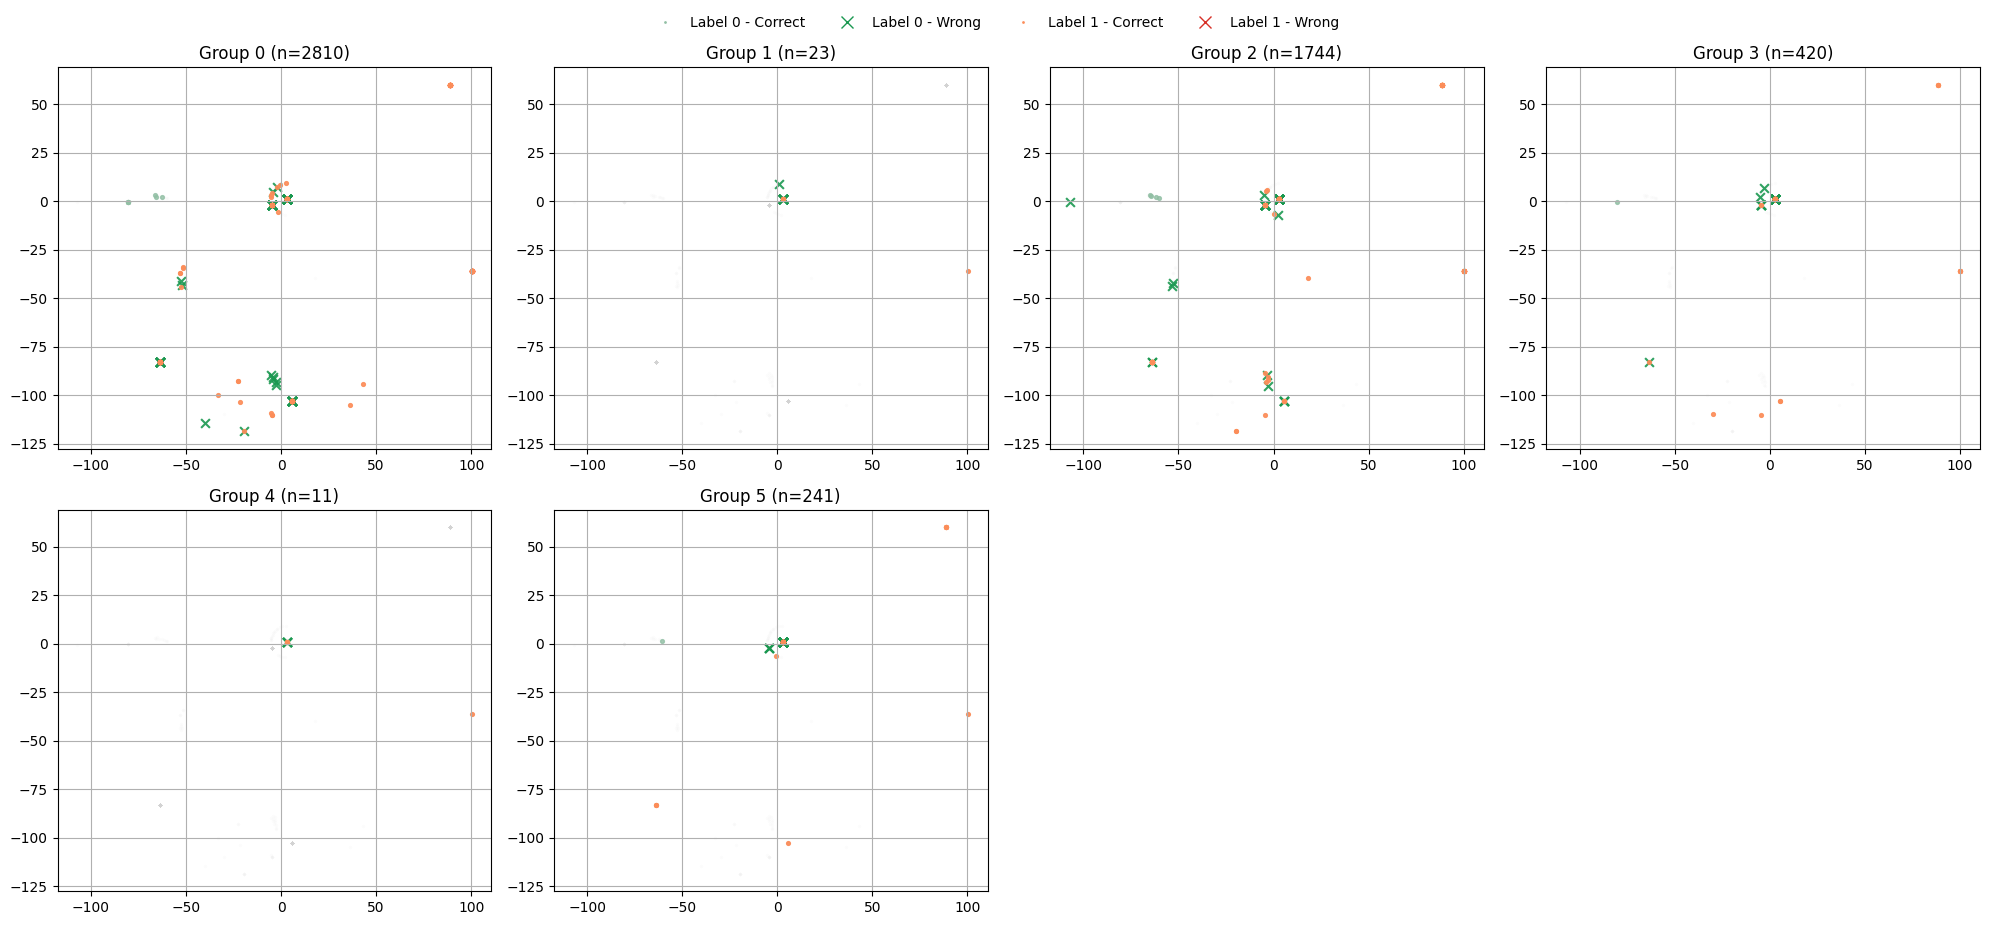

In [70]:
plot_tsne_groupwise_label_correctness(models[3], test_loader, device)

In [ ]:
evaluate_group_metrics(model, test_loader, device)

# gsr-plus

In [ ]:
config = {
  "dataset": "adult",
  "model_type": "node",
  "method": "gsr-plus",
  "model_params": {
    "input_dim": 12,
    "hidden_dim": 64,
    "num_trees": 5,
    "depth": 3,
    "num_classes": 2
  },
  "train_params": {
    "epochs": 100,
    "lr": 0.001
  }
}

In [ ]:
from method.gsr_plus import run_gsr_plus
from models import node

METHODS = {
    'gsr-plus' : run_gsr_plus,
}


model_class = MODEL_CLASSES[config['model_type']]
model = model_class(config['model_params']).to(device)
method_fn = METHODS[config["method"]]  
dataset = config['dataset']


model_rep, best_model_final = run_gsr_plus(
    model, train_loader, valid_loader, test_loader,
    train_df, config['train_params'], device, dataset, config["method"]
)

# 테스트셋에서 그룹별 F1/Recall 평가
evaluate_group_metrics(best_model_final, test_loader, device)

In [ ]:
evaluate_group_metrics(model_rep, test_loader, device)